# Forest fire

This is a demonstration of the [agentpy](https://agentpy.readthedocs.io) package, presenting an agent-based model that simulates a forest fire. 
It shows how to to work with a spacial grid, create animations, and perform a parameter sweep. 

The [original model](http://ccl.northwestern.edu/netlogo/models/FireSimple) has been designed in Netlogo by Uri Wilensky and William Rand (2015), who describe it as follows:

> "This model simulates the spread of a fire through a forest. It shows that the fire's chance of reaching the right edge of the forest depends critically on the density of trees. This is an example of a common feature of complex systems, the presence of a non-linear threshold or critical parameter. [...] 
>
> The fire starts on the left edge of the forest, and spreads to neighboring trees. The fire spreads in four directions: north, east, south, and west.
>
>The model assumes there is no wind. So, the fire must have trees along its path in order to advance. That is, the fire cannot skip over an unwooded area (patch), so such a patch blocks the fire's motion in that direction."

In [1]:
# Import libraries

import agentpy as ap
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns # Statistical data visualization

from IPython.display import HTML # To display animations

## Model definition

In [2]:
class forest_model(ap.Model):
    
    def setup(self):
        
        # Create grid (forest)
        x = y = self.p.size # Access parameter
        self.add_grid('forest', shape=(x,y))
        
        # Create agents (trees) 
        n_trees = int(self.p.density * x * y)
        self.forest.add_agents(n_trees, random=True)
        
        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Burned
        self.agents.condition = 0 
        
        # Start a fire from the left side of the grid
        unfortunate_trees = self.forest.area([(0,x),(0,0)])
        unfortunate_trees.condition = 1 
        
    def step(self):
        
        # Select burning trees
        burning_trees = self.agents(self.agents.condition == 1)

        # Spread fire 
        for agent in burning_trees:
            for neighbor in agent.neighbors():
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            agent.condition = 2 # Tree burns out  
        
        # Stop simulation if no fire is left
        if len(burning_trees) == 0: self.stop()
            
    def end(self):
        
        # Document a measure at the end of the simulation
        burned_trees = len(self.agents(self.agents.condition == 2)) / len(self.agents)
        self.measure('Percentage of burned trees', burned_trees )

## Single-run animation

In [3]:
# Define parameters

parameters = {
    'density': 0.6, # Percentage of grid covered by trees
    'size': 100 # Height and length of the grid
    }

In [4]:
# Create single-run animation

def animation_plot(model,ax):
    
    color_dict = { 'empty': 'w', 0:'g' , 1:'r', 2:'grey'}
    ap.gridplot(model,ax,'forest','condition',color_dict)

fig, ax = plt.subplots(figsize=(7,7)) 
animation = ap.animate(forest_model, parameters, fig, ax, animation_plot)
HTML(animation.to_jshtml())

## Parameter sweep

In [5]:
# Prepare parameter sample
# Arranges 50 values for density from 0.1 to 1

parameter_ranges = {
    'density': (0.1,1), 
    'size': 100 
    }

sample = ap.sample(parameter_ranges, n=50)

In [6]:
# Perform experiment
# Repeats simulation 20 times for each value of density

exp = ap.Experiment(forest_model, sample, iterations = 20)
results = exp.run()
results.save()

Scheduled runs: 1000
Completed: 1000, estimated time remaining: 0:00:00
Run time: 0:11:06.679322
Simulation finished
Data saved to ap_output/forest_model_1


In [7]:
# Load saved output data

results = ap.load('forest_model')

Loading from directory ap_output/forest_model_1/
Loading log.json - Successful
Loading measures.csv - Successful
Loading parameters_fixed.json - Successful
Loading parameters_varied.csv - Successful


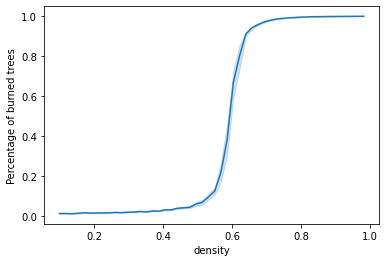

In [8]:
# Plot sensitivity
# Every point shows average over 50 runs

data = results.arrange(('measures','parameters'))  # Create plotting data
ax = sns.lineplot(data=data, x='density', y='Percentage of burned trees')

## References

Wilensky, U. & Rand, W. (2015). Introduction to Agent-Based Modeling: Modeling Natural, Social and Engineered Complex Systems with NetLogo. Cambridge, MA. MIT Press.